# 문제정의

In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from tqdm.auto import tqdm
from scipy import stats
import tensorflow as tf
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.preprocessing import StandardScaler
import time

In [10]:
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [2]:
train_data = pd.read_csv('dataset/train_data.csv')
test_data = pd.read_csv('dataset/test_data.csv')
submission = pd.read_csv('dataset/answer_sample.csv')

In [3]:
submission['label'] = 0

In [26]:
train_data

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type
0,-0.448257,-0.917212,0.0,-0.511748,-1.007046,-0.910351,-0.910351,0
1,0.699749,1.178320,0.0,0.802045,1.118785,1.172883,1.172883,0
2,-0.182053,-0.425427,0.0,-0.202966,-0.508305,-0.421612,-0.421612,0
3,0.200616,0.266970,0.0,0.230799,0.194005,0.265958,0.265958,0
4,-0.190372,-0.434598,0.0,-0.208848,-0.517029,-0.430592,-0.430592,0
...,...,...,...,...,...,...,...,...
2458,0.125746,0.137432,0.0,0.149927,0.063140,0.137680,0.137680,7
2459,-0.073907,-0.236279,0.0,-0.084600,-0.316369,-0.234326,-0.234326,7
2460,-0.781013,-1.520194,0.0,-0.889638,-1.619204,-1.510693,-1.510693,7
2461,-0.764375,-1.490389,0.0,-0.871259,-1.588669,-1.481189,-1.481189,7


In [4]:
train_data.shape

(2463, 8)

In [5]:
train_data

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type
0,1.59,41.00,0.7,20.53,1680.0,58.67,2.93,0
1,2.97,59.28,0.7,38.40,3142.0,74.91,3.75,0
2,1.91,45.29,0.7,24.73,2023.0,62.48,3.12,0
3,2.37,51.33,0.7,30.63,2506.0,67.84,3.39,0
4,1.90,45.21,0.7,24.65,2017.0,62.41,3.12,0
...,...,...,...,...,...,...,...,...
2458,2.28,50.20,0.7,29.53,2416.0,66.84,3.34,7
2459,2.04,46.94,0.7,26.34,2155.0,63.94,3.20,7
2460,1.19,35.74,0.7,15.39,1259.0,53.99,2.70,7
2461,1.21,36.00,0.7,15.64,1280.0,54.22,2.71,7


In [27]:
# TAG_MIN = train_data.min()
# TAG_MAX = train_data.max()

In [121]:
def normalize(df):
    ndf = df.copy()
    TAG_MIN = df.min()
    TAG_MAX = df.max()
    for c in df.columns:
        if TAG_MIN[c] == TAG_MAX[c]:
            ndf[c] = df[c] - TAG_MIN[c]
        else:
            ndf[c] = (df[c] - TAG_MIN[c]) / (TAG_MAX[c] - TAG_MIN[c])
    return ndf

In [124]:
train_data_nor = normalize(train_data[train_data['type']==1].drop(columns=['type']))
train_data_nor

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe
432,0.698630,0.726583,0.0,0.716376,0.751492,0.723679,0.723679
433,0.410959,0.426121,0.0,0.420009,0.440750,0.424455,0.424455
434,0.424658,0.443931,0.0,0.437471,0.459079,0.442187,0.442187
435,0.794521,0.820251,0.0,0.808872,0.848252,0.817141,0.817141
436,0.664384,0.687665,0.0,0.677678,0.710997,0.684891,0.684891
...,...,...,...,...,...,...,...
796,0.006849,0.006596,0.0,0.006607,0.006820,0.006649,0.006649
797,0.102740,0.108179,0.0,0.106654,0.112106,0.108238,0.108238
798,0.082192,0.090699,0.0,0.089193,0.093777,0.090506,0.090506
799,0.726027,0.749340,0.0,0.738556,0.774936,0.746214,0.746214


In [125]:
def boundary_check(df):
    x = np.array(df, dtype=np.float32)
    print(x)
    return np.any(x > 1.0), np.any(x < 0), np.any(np.isnan(x))

In [126]:
boundary_check(train_data_nor)

[[0.69863015 0.7265831  0.         ... 0.7514919  0.72367936 0.72367936]
 [0.41095892 0.42612138 0.         ... 0.4407502  0.4244551  0.4244551 ]
 [0.42465752 0.4439314  0.         ... 0.4590793  0.44218692 0.44218692]
 ...
 [0.08219178 0.09069921 0.         ... 0.09377664 0.09050609 0.09050609]
 [0.72602737 0.74934036 0.         ... 0.7749361  0.7462135  0.7462135 ]
 [0.09589041 0.09894459 0.         ... 0.10230179 0.09863317 0.09863317]]


(False, False, False)

In [127]:
# scaler1 = StandardScaler()
# scaler2 = StandardScaler()
# scaler3 = StandardScaler()
# scaler4 = StandardScaler()
# scaler5 = StandardScaler()
# scaler6 = StandardScaler()
# scaler7 = StandardScaler()
# scaler8 = StandardScaler()

# train_data['air_inflow'] = scaler1.fit_transform(train_data['air_inflow'].values.reshape(-1, 1))
# train_data['air_end_temp'] = scaler2.fit_transform(train_data['air_end_temp'].values.reshape(-1, 1))
# train_data['out_pressure'] = scaler3.fit_transform(train_data['out_pressure'].values.reshape(-1, 1))
# train_data['motor_current'] = scaler4.fit_transform(train_data['motor_current'].values.reshape(-1, 1))
# train_data['motor_rpm'] = scaler5.fit_transform(train_data['motor_rpm'].values.reshape(-1, 1))
# train_data['motor_temp'] = scaler6.fit_transform(train_data['motor_temp'].values.reshape(-1, 1))
# train_data['motor_vibe'] = scaler7.fit_transform(train_data['motor_temp'].values.reshape(-1, 1))

In [128]:
X_train, X_test = train_test_split(train_data_nor, test_size=0.3, random_state=RANDOM_SEED)
X_train.shape

(258, 7)

In [151]:
from tensorflow.keras import layers

In [152]:
input_dim = X_train.shape[1]
encoding_dim = 14
input_layer = Input(shape=(input_dim, ))

7

In [ ]:
def conv_auto_model(x):
    n_steps = x.shape[1]
    n_features = x.shape[2]

    keras.backend.clear_session()

    model = keras.Sequential(
        [
            layers.Input(shape=(n_steps, n_features)),
            layers.Conv1D(filters=512, kernel_size=64, padding='same', data_format='channels_last',
                          dilation_rate=1, activation="linear"),
            layers.Dense(128),
            layers.LSTM(
                units=64, activation="relu", name="lstm_1", return_sequences=False
            ),
            layers.Dense(64),
            layers.RepeatVector(n_steps),
            layers.Dense(64),
            layers.LSTM(
                units=64, activation="relu", name="lstm_2", return_sequences=True
            ),
            layers.Dense(128),
            layers.Conv1D(filters=512, kernel_size=64, padding='same', data_format='channels_last',
                          dilation_rate=1, activation="linear"),
            layers.Dense()
        ]
    )
    return model

In [129]:
input_dim = X_train.shape[1]
encoding_dim = 14
input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="relu",
               activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(input_dim, activation="relu")(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [130]:
nb_epoch = 200
batch_size = 32
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/200
9/9 [==============================] - 1s 20ms/step - loss: 0.2260 - accuracy: 0.1202 - val_loss: 0.2318 - val_accuracy: 0.1802
Epoch 2/200
9/9 [==============================] - 0s 6ms/step - loss: 0.2096 - accuracy: 0.1550 - val_loss: 0.2127 - val_accuracy: 0.2342
Epoch 3/200
9/9 [==============================] - 0s 6ms/step - loss: 0.1906 - accuracy: 0.3217 - val_loss: 0.1921 - val_accuracy: 0.5676
Epoch 4/200
9/9 [==============================] - 0s 6ms/step - loss: 0.1713 - accuracy: 0.8062 - val_loss: 0.1724 - val_accuracy: 0.8739
Epoch 5/200
9/9 [==============================] - 0s 7ms/step - loss: 0.1532 - accuracy: 0.8566 - val_loss: 0.1548 - val_accuracy: 0.8739
Epoch 6/200
9/9 [==============================] - 0s 7ms/step - loss: 0.1384 - accuracy: 0.8527 - val_loss: 0.1396 - val_accuracy: 0.8198
Epoch 7/200
9/9 [==============================] - 0s 7ms/step - loss: 0.1252 - accuracy: 0.7713 - val_loss: 0.1269 - val_accuracy: 0.6486
Epoch 8/200
9/9 [=========

9/9 [==============================] - 0s 6ms/step - loss: 0.0421 - accuracy: 0.7016 - val_loss: 0.0451 - val_accuracy: 0.7297
Epoch 60/200
9/9 [==============================] - 0s 6ms/step - loss: 0.0421 - accuracy: 0.7326 - val_loss: 0.0451 - val_accuracy: 0.7387
Epoch 61/200
9/9 [==============================] - 0s 6ms/step - loss: 0.0421 - accuracy: 0.7248 - val_loss: 0.0451 - val_accuracy: 0.7297
Epoch 62/200
9/9 [==============================] - 0s 4ms/step - loss: 0.0421 - accuracy: 0.7326 - val_loss: 0.0451 - val_accuracy: 0.6937
Epoch 63/200
9/9 [==============================] - 0s 4ms/step - loss: 0.0421 - accuracy: 0.7171 - val_loss: 0.0451 - val_accuracy: 0.7117
Epoch 64/200
9/9 [==============================] - 0s 4ms/step - loss: 0.0421 - accuracy: 0.7093 - val_loss: 0.0451 - val_accuracy: 0.7477
Epoch 65/200
9/9 [==============================] - 0s 4ms/step - loss: 0.0421 - accuracy: 0.7752 - val_loss: 0.0451 - val_accuracy: 0.7928
Epoch 66/200
9/9 [===============

9/9 [==============================] - 0s 4ms/step - loss: 0.0421 - accuracy: 0.7946 - val_loss: 0.0451 - val_accuracy: 0.8198
Epoch 118/200
9/9 [==============================] - 0s 4ms/step - loss: 0.0421 - accuracy: 0.7016 - val_loss: 0.0451 - val_accuracy: 0.8018
Epoch 119/200
9/9 [==============================] - 0s 6ms/step - loss: 0.0421 - accuracy: 0.7868 - val_loss: 0.0451 - val_accuracy: 0.8649
Epoch 120/200
9/9 [==============================] - 0s 4ms/step - loss: 0.0421 - accuracy: 0.7519 - val_loss: 0.0451 - val_accuracy: 0.6667
Epoch 121/200
9/9 [==============================] - 0s 6ms/step - loss: 0.0421 - accuracy: 0.6744 - val_loss: 0.0451 - val_accuracy: 0.7387
Epoch 122/200
9/9 [==============================] - 0s 6ms/step - loss: 0.0421 - accuracy: 0.6667 - val_loss: 0.0451 - val_accuracy: 0.6577
Epoch 123/200
9/9 [==============================] - 0s 6ms/step - loss: 0.0421 - accuracy: 0.6705 - val_loss: 0.0451 - val_accuracy: 0.6757
Epoch 124/200
9/9 [========

9/9 [==============================] - 0s 6ms/step - loss: 0.0421 - accuracy: 0.8140 - val_loss: 0.0451 - val_accuracy: 0.8288
Epoch 176/200
9/9 [==============================] - 0s 5ms/step - loss: 0.0421 - accuracy: 0.7519 - val_loss: 0.0451 - val_accuracy: 0.7207
Epoch 177/200
9/9 [==============================] - 0s 4ms/step - loss: 0.0421 - accuracy: 0.6085 - val_loss: 0.0451 - val_accuracy: 0.6486
Epoch 178/200
9/9 [==============================] - 0s 6ms/step - loss: 0.0421 - accuracy: 0.6047 - val_loss: 0.0451 - val_accuracy: 0.7297
Epoch 179/200
9/9 [==============================] - 0s 4ms/step - loss: 0.0421 - accuracy: 0.7326 - val_loss: 0.0451 - val_accuracy: 0.7928
Epoch 180/200
9/9 [==============================] - 0s 6ms/step - loss: 0.0421 - accuracy: 0.8101 - val_loss: 0.0451 - val_accuracy: 0.8468
Epoch 181/200
9/9 [==============================] - 0s 6ms/step - loss: 0.0421 - accuracy: 0.8140 - val_loss: 0.0451 - val_accuracy: 0.8468
Epoch 182/200
9/9 [========

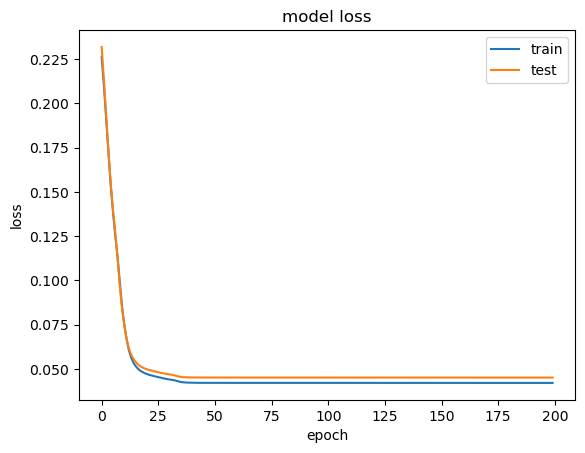

In [131]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [145]:
test_data_nor = normalize(train_data[train_data['type']==1].drop(columns=['type']))
boundary_check(test_data_nor)

[[0.69863015 0.7265831  0.         ... 0.7514919  0.72367936 0.72367936]
 [0.41095892 0.42612138 0.         ... 0.4407502  0.4244551  0.4244551 ]
 [0.42465752 0.4439314  0.         ... 0.4590793  0.44218692 0.44218692]
 ...
 [0.08219178 0.09069921 0.         ... 0.09377664 0.09050609 0.09050609]
 [0.72602737 0.74934036 0.         ... 0.7749361  0.7462135  0.7462135 ]
 [0.09589041 0.09894459 0.         ... 0.10230179 0.09863317 0.09863317]]


(False, False, False)

<AxesSubplot:>

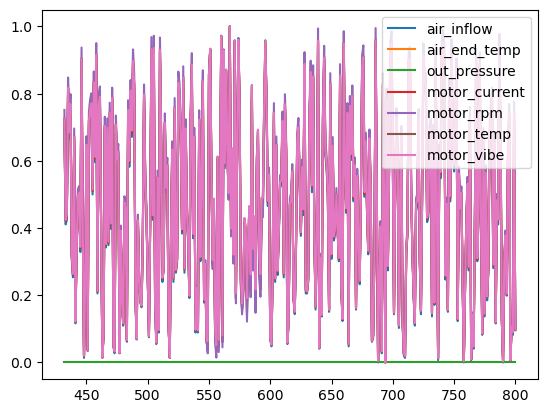

In [146]:
test_data_nor.plot()

In [147]:
x_val = np.array(test_data_nor)
x_val.shape

(369, 7)

In [148]:
start = time.time()
valid_x_predictions = autoencoder.predict(x_val)
print(valid_x_predictions.shape)

error = x_val - valid_x_predictions
print((x_val - valid_x_predictions).shape)

valid_mse = np.mean(np.power(x_val - valid_x_predictions, 2), axis=1)
print(valid_mse.shape)
print(time.time()-start)

12/12 [==============================] - 0s 567us/step
(369, 7)
(369, 7)
(369,)
0.05333662033081055


In [149]:
error_df = pd.DataFrame({'Reconstruction_error': valid_mse})
# fig, ax = plt.subplots(figsize=(20,20))
error_df.Reconstruction_error

0      0.074837
1      0.025757
2      0.027954
3      0.095401
4      0.067025
         ...   
364    0.000038
365    0.001679
366    0.001177
367    0.079560
368    0.001394
Name: Reconstruction_error, Length: 369, dtype: float64

Text(0.5, 0, 'Data point index')

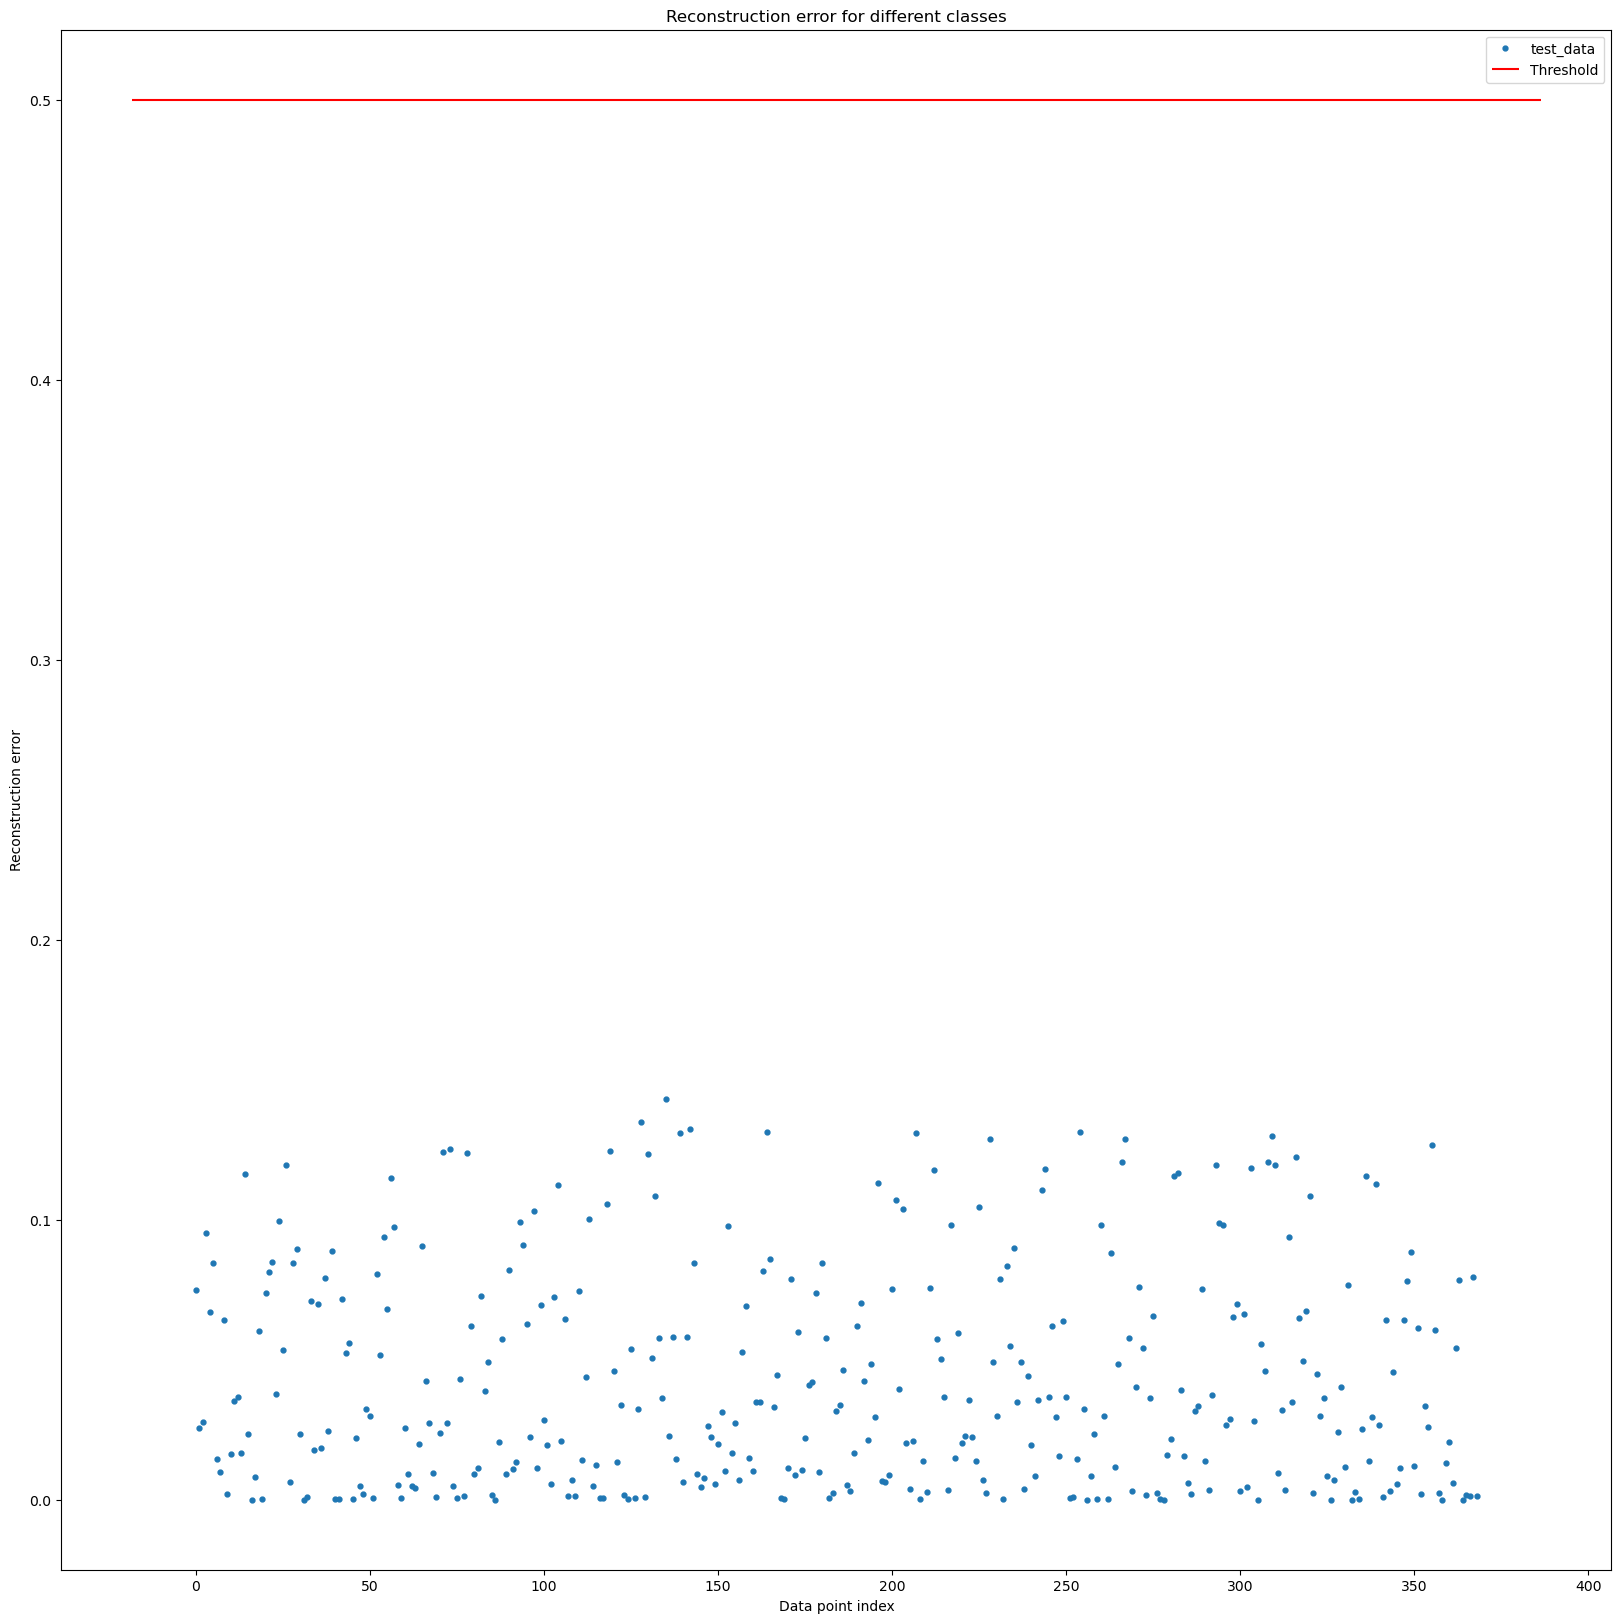

In [150]:
error_df = pd.DataFrame({'Reconstruction_error': valid_mse})
fig, ax = plt.subplots(figsize=(20,20))

ax.plot(error_df.index, error_df.Reconstruction_error, marker='o', ms=3.5, linestyle='',
        label= "test_data")
    
ax.hlines(0.5, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()

plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")

In [120]:
test_data['type'].value_counts()

0    1296
1    1107
2    1098
3     918
4     918
5     747
6     747
7     558
Name: type, dtype: int64